# Data exploration of data in timestream db


## Initialization


In [104]:
import awswrangler as wr
import pandas as pd
import scipy.signal as signal
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context("paper")

SENSORS: set[str] = {"PWS_1", "PWS_2", "PWS_3"}


def remove_ascends(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove ascends from the dataframe. Must have peaks and valleys as values
    """
    last_peak = -1
    last_valley = 0
    for row in df.itertuples():
        if row.peak:
            last_peak = row.Index
        if last_peak < last_valley:
            df.drop(row.Index, inplace=True)
        if row.valley:
            last_valley = row.Index
    return df


## Data retrieval


In [105]:
df: pd.DataFrame = wr.timestream.query('SELECT * FROM "when-to-water"."sensor-data"')


In [106]:
print(f"Retrived {len(df)} records")
df["time"] = pd.to_datetime(df["time"])
df.sort_values(by="time")
df_counts = df.groupby(["sensor_name", "measure_name", df["time"].dt.floor('d')]).size().reset_index(name="count")
df_counts = df_counts.groupby(["sensor_name"]).median().rename(columns={"count": "median records per day"})
MEDIANS = df_counts.to_dict()["median records per day"]
print(f"Medians: {MEDIANS}")
df_max = df.groupby(["sensor_name", "measure_name", df["time"].dt.floor('d')]).max()


Retrived 8084 records
Medians: {'PWS_1': 9.0, 'PWS_2': 9.0, 'PWS_3': 9.0}


### Transformations


In [107]:

df_soil_moisture = df[df["measure_name"] == "soil_moisture"].rename(columns={"measure_value::double": "soil moisture in %"})
df_soil_moisture = df_soil_moisture[df_soil_moisture["soil moisture in %"] > 2]
moisture_dfs: dict[pd.DataFrame] = {}
valleys_dfs: dict[pd.DataFrame] = {}
for sensor_name in SENSORS:
    moisture_dfs[sensor_name] = df_soil_moisture[df_soil_moisture["sensor_name"] == sensor_name].copy()
    moisture_dfs[sensor_name]["soil moisture in %"] = moisture_dfs[sensor_name]["soil moisture in %"].rolling(5).mean()
    moisture_dfs[sensor_name].reset_index(inplace=True)
    peaks = signal.find_peaks(moisture_dfs[sensor_name]["soil moisture in %"], distance=MEDIANS[sensor_name]/2, prominence=3)[0]
    valleys = signal.find_peaks(-moisture_dfs[sensor_name]["soil moisture in %"], distance=MEDIANS[sensor_name]/2, prominence=3)[0]
    moisture_dfs[sensor_name]["peak"] = moisture_dfs[sensor_name].index.isin(peaks)
    moisture_dfs[sensor_name]["valley"] = moisture_dfs[sensor_name].index.isin(valleys)
    moisture_dfs[sensor_name] = remove_ascends(moisture_dfs[sensor_name])
moisture_dfs = dict(sorted(moisture_dfs.items()))
df_soil_moisture = pd.concat([*moisture_dfs.values()]).reset_index()
df_peaks = df_soil_moisture[df_soil_moisture["peak"] == True].reindex(["time", "sensor_name"], axis=1)
df_valleys = df_soil_moisture[df_soil_moisture["valley"] == True].reindex(["time", "sensor_name"], axis=1)


## Plots


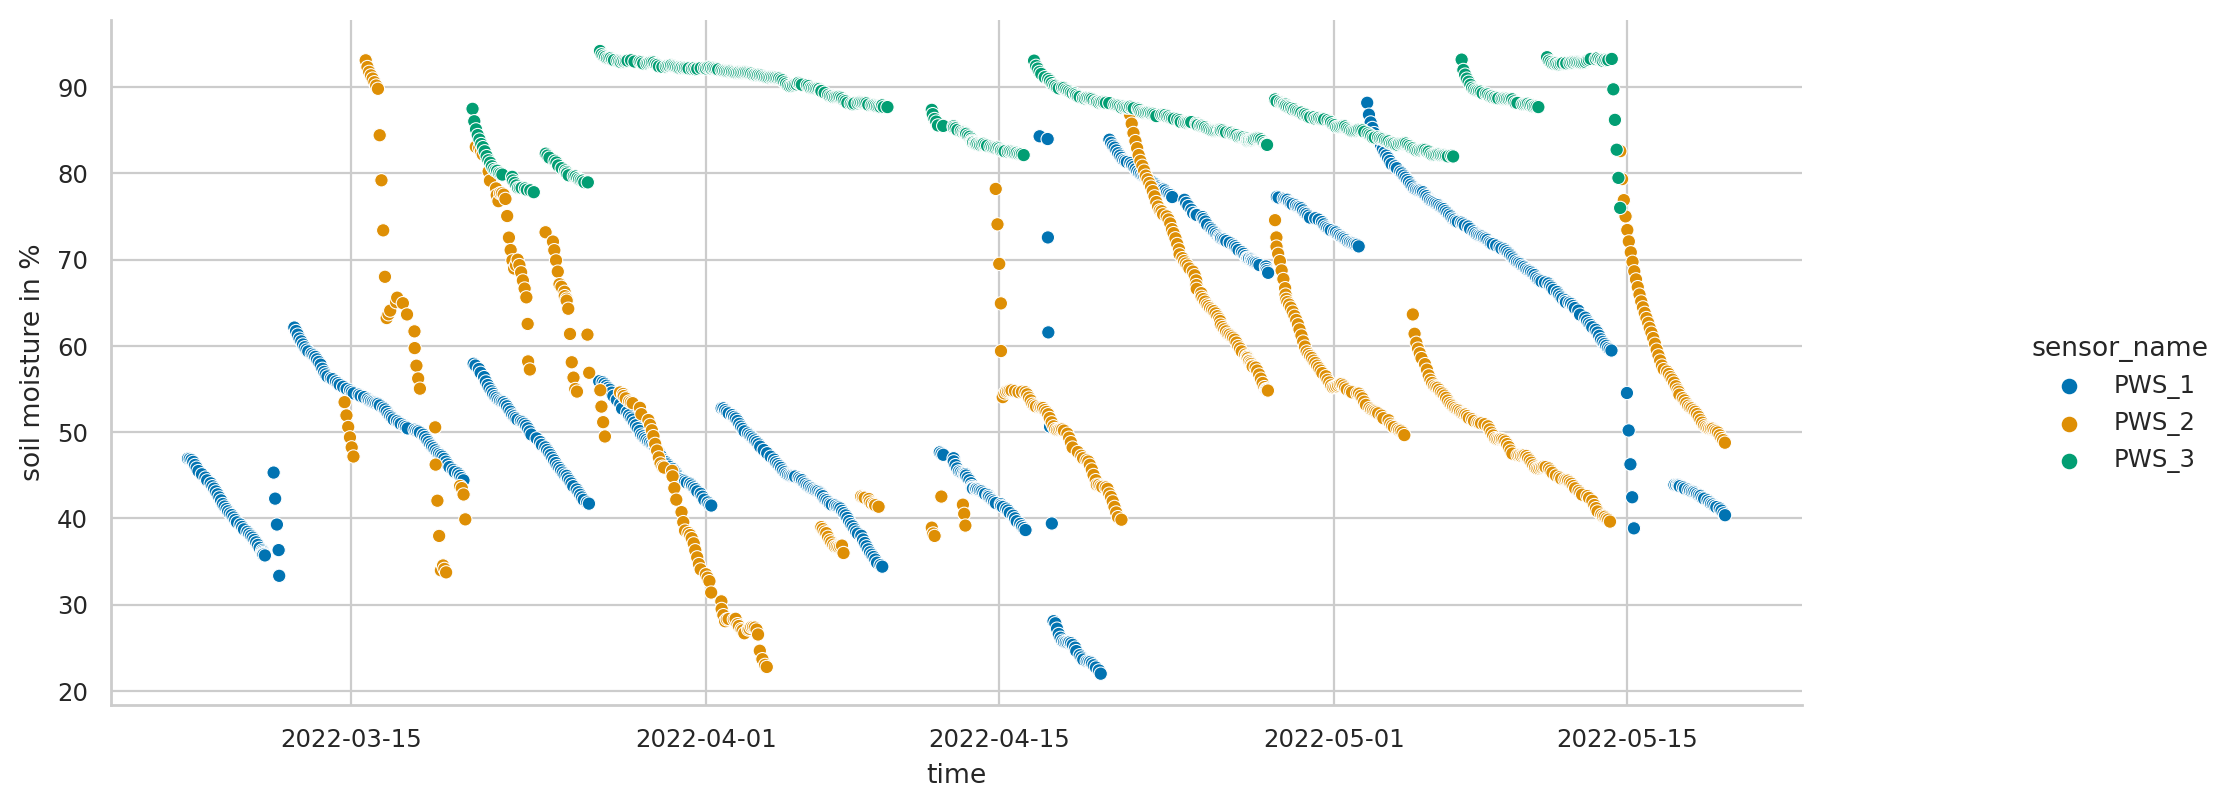

In [108]:
plot = sns.relplot(x="time", y="soil moisture in %", hue="sensor_name", data=df_soil_moisture, palette="colorblind", kind="scatter")
plot.figure.set_size_inches(12, 4)
colors = {
    "PWS_1": sns.palettes.color_palette("colorblind")[0],
    "PWS_2": sns.palettes.color_palette("colorblind")[1],
    "PWS_3": sns.palettes.color_palette("colorblind")[2]
}
# for time, sensor_name in zip(df_peaks['time'], df_peaks['sensor_name']):
#     plot.refline(x = time,
#             color = colors.get(sensor_name),
#             lw = 1)

# for time, sensor_name in zip(df_valleys['time'], df_valleys['sensor_name']):
#     plot.refline(x = time,
#             color = colors.get(sensor_name),
#             lw = 1)

sns.despine()